# <center> ***Anomaly-Driven Video Summarization***</center>

#### **Vishnu Priyan Sellam Shanmugavel**
#### **A20561323**
#### **CS512 - F24** 

<a id="im"></a>
# <center>IMPORTING LIBRARIES</center> 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


from IPython.display import clear_output
import warnings
# warnings.filterwarnings('ignore')

import cv2
import numpy as np


<a id="hp"></a>
# <center>HYPERPARAMETRERS AND DIRECTORIES</center>

In [11]:
train_dir = "dataset/UCF_Crime_Organized/Train"
test_dir = "dataset/UCF_Crime_Organized/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 10
LR =  0.00003
NUM_CLASSES = 14
IMG_WIDTH = 64
NUM_FRAMES = 16  # Desired number of frames per video
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"NormalVideos",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

<a id="data"></a>
# <center> DATA LOADING AND PRE-PROCESSING</center>

In [12]:
def flow_to_color(flow, max_flow=None):
    """Convert optical flow to RGB image."""
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    if max_flow is not None:
        magnitude = cv2.normalize(magnitude, None, 0, max_flow, cv2.NORM_MINMAX)

    hue = angle * 180 / np.pi / 2
    saturation = np.ones_like(hue) * 255
    value = magnitude * 255 / np.max(magnitude)

    hsv = np.stack((hue, saturation, value), axis=-1).astype(np.uint8)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return rgb


In [13]:
def compute_optical_flow(video_frames_dir):
    # Open video file
    frame_files = sorted([os.path.join(video_frames_dir, f) for f in os.listdir(video_frames_dir) if f.endswith('.png')])
    optical_flow_data = []
    
    print(f"Total frames for optical flow computation: {len(frame_files)}")
    
    for i in range(len(frame_files) - 1):
        prev_frame = cv2.imread(frame_files[i])
        next_frame = cv2.imread(frame_files[i + 1])
        
        if prev_frame is not None and next_frame is not None:
            prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
            next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

            flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            rgb_flow = flow_to_color(flow)
            optical_flow_data.append(rgb_flow)
            # optical_flow_data.append(flow)

            # Print status
            if i % 10 == 0:  # Print every 10 frames
                print(f"Processed frames: {i} to {i + 1}")

    print(f"Computed optical flow for {len(optical_flow_data)} frames.")
    target_frames =200
    if len(optical_flow_data) < target_frames:
        # Pad with zero arrays if not enough frames
        padding_needed = target_frames - len(optical_flow_data)
        optical_flow_data.extend([np.zeros_like(optical_flow_data[0])] * padding_needed)
        print(f"Padded with {padding_needed} empty frames to reach {target_frames} frames.")
    elif len(optical_flow_data) > target_frames:
        # Sample down to target_frames if too many
        indices = np.random.choice(len(optical_flow_data), target_frames, replace=False)
        optical_flow_data = [optical_flow_data[i] for i in indices]
        print(f"Sampled down to {target_frames} frames from {len(optical_flow_data)} optical flow frames.")

    
    return np.array(optical_flow_data)

def extract_key_frames(video_frames_dir, threshold=30):
    frame_files = sorted([os.path.join(video_frames_dir, f) for f in os.listdir(video_frames_dir) if f.endswith('.png')])
    key_frames = []
    
    print(f"Total frames for key frame extraction: {len(frame_files)}")
    
    prev_frame = cv2.imread(frame_files[0])
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    for frame_path in frame_files[1:]:
        current_frame = cv2.imread(frame_path)
        current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        
        diff = cv2.absdiff(prev_gray, current_gray)
        non_zero_count = np.count_nonzero(diff)
        
        if non_zero_count > threshold:
            key_frames.append(current_frame)
            print(f"Key frame detected: {frame_path}, Non-zero pixel count: {non_zero_count}")

        prev_gray = current_gray
    
    print(f"Extracted {len(key_frames)} key frames.")
    target_frames =200
    # Adjust to ensure exactly target_frames frames
    if len(key_frames) < target_frames:
        # Pad with empty frames if not enough
        padding_needed = target_frames - len(key_frames)
        key_frames.extend([np.zeros_like(key_frames[0])] * padding_needed)
        print(f"Padded with {padding_needed} empty frames to reach {target_frames} frames.")
    elif len(key_frames) > target_frames:
        # Sample down to target_frames if too many
        indices = np.random.choice(len(key_frames), target_frames, replace=False)
        key_frames = [key_frames[i] for i in indices]
        print(f"Sampled down to {target_frames} frames from {len(key_frames)} key frames.")
    
    return np.array(key_frames)


In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2

# Initialize LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(CLASS_LABELS)

def process_frames(video_frames_dir, num_frames=NUM_FRAMES, img_height=IMG_HEIGHT, img_width=IMG_WIDTH):
    # Get all frame file paths and sort them
    frame_files = sorted([os.path.join(video_frames_dir, f) for f in os.listdir(video_frames_dir) if f.endswith('.png')])
    total_frames = len(frame_files)
    
    # Determine step to sample frames uniformly if there are more frames than needed
    step = max(1, total_frames // num_frames)
    selected_frames = frame_files[::step][:num_frames]
    
    # Load and resize frames
    frames = []
    for frame_path in selected_frames:
        img = cv2.imread(frame_path)
        if img is not None:
            img = cv2.resize(img, (img_width, img_height))
            frames.append(img)
    
    # Pad with black frames if necessary
    while len(frames) < num_frames:
        frames.append(np.zeros((img_height, img_width, 3), dtype=np.uint8))
    
    # Convert frames to numpy array and normalize
    return np.array(frames) / 255.0

def load_dataset(data_dir):
    X_data = []
    y_data = []
    for class_label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_label)
        if os.path.isdir(class_dir):
            for video_folder in os.listdir(class_dir):
                video_frames_dir = os.path.join(class_dir, video_folder)
                if os.path.isdir(video_frames_dir):
                    # if method == 'optical_flow':
                    frames = compute_optical_flow(video_frames_dir)
                    # elif method == 'key_frames':
                    # frames = extract_key_frames(video_frames_dir)
                    # # elif method == 'sampling':
                    # frames = process_frames(video_frames_dir)
                    X_data.append(frames)
                    y_data.append(class_label)
    
    # Encode labels
    y_data = label_encoder.transform(y_data)
    y_data = to_categorical(y_data, num_classes=len(CLASS_LABELS))
    return np.array(X_data), np.array(y_data)

# Load Train and Test Data
X_train, y_train = load_dataset(train_dir)
X_test, y_test = load_dataset(test_dir)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Total frames for optical flow computation: 23
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Computed optical flow for 22 frames.
Padded with 178 empty frames to reach 200 frames.
Total frames for optical flow computation: 149
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Processed frames: 30 to 31
Processed frames: 40 to 41
Processed frames: 50 to 51
Processed frames: 60 to 61
Processed frames: 70 to 71
Processed frames: 80 to 81
Processed frames: 90 to 91
Processed frames: 100 to 101
Processed frames: 110 to 111
Processed frames: 120 to 121
Processed frames: 130 to 131
Processed frames: 140 to 141
Computed optical flow for 148 frames.
Padded with 52 empty frames to reach 200 frames.
Total frames for optical flow computation: 111
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Processed frames: 30 to 31
Processed frames: 40 to 41
Processed frames: 50 to 51
Processed frames: 60 to 61
Process

/var/folders/7c/b_r60m_j6pn7sx9n8ffpn2980000gn/T/ipykernel_85402/1548787475.py:9: RuntimeWarning: invalid value encountered in divide
  value = magnitude * 255 / np.max(magnitude)
/var/folders/7c/b_r60m_j6pn7sx9n8ffpn2980000gn/T/ipykernel_85402/1548787475.py:11: RuntimeWarning: invalid value encountered in cast
  hsv = np.stack((hue, saturation, value), axis=-1).astype(np.uint8)


Processed frames: 100 to 101
Computed optical flow for 109 frames.
Padded with 91 empty frames to reach 200 frames.
Total frames for optical flow computation: 69
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Processed frames: 30 to 31
Processed frames: 40 to 41
Processed frames: 50 to 51
Processed frames: 60 to 61
Computed optical flow for 68 frames.
Padded with 132 empty frames to reach 200 frames.
Total frames for optical flow computation: 180
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Processed frames: 30 to 31
Processed frames: 40 to 41
Processed frames: 50 to 51
Processed frames: 60 to 61
Processed frames: 70 to 71
Processed frames: 80 to 81
Processed frames: 90 to 91
Processed frames: 100 to 101
Processed frames: 110 to 111
Processed frames: 120 to 121
Processed frames: 130 to 131
Processed frames: 140 to 141
Processed frames: 150 to 151
Processed frames: 160 to 161
Processed frames: 170 to 171
Computed optical 

/var/folders/7c/b_r60m_j6pn7sx9n8ffpn2980000gn/T/ipykernel_85402/1548787475.py:9: RuntimeWarning: invalid value encountered in divide
  value = magnitude * 255 / np.max(magnitude)
/var/folders/7c/b_r60m_j6pn7sx9n8ffpn2980000gn/T/ipykernel_85402/1548787475.py:11: RuntimeWarning: invalid value encountered in cast
  hsv = np.stack((hue, saturation, value), axis=-1).astype(np.uint8)


Processed frames: 230 to 231
Processed frames: 240 to 241
Processed frames: 250 to 251
Processed frames: 260 to 261
Processed frames: 270 to 271
Processed frames: 280 to 281
Processed frames: 290 to 291
Processed frames: 300 to 301
Processed frames: 310 to 311
Computed optical flow for 315 frames.
Sampled down to 200 frames from 200 optical flow frames.
Total frames for optical flow computation: 144
Processed frames: 0 to 1
Processed frames: 10 to 11
Processed frames: 20 to 21
Processed frames: 30 to 31
Processed frames: 40 to 41
Processed frames: 50 to 51
Processed frames: 60 to 61
Processed frames: 70 to 71
Processed frames: 80 to 81
Processed frames: 90 to 91
Processed frames: 100 to 101
Processed frames: 110 to 111
Processed frames: 120 to 121
Processed frames: 130 to 131
Processed frames: 140 to 141
Computed optical flow for 143 frames.
Padded with 57 empty frames to reach 200 frames.
Total frames for optical flow computation: 75
Processed frames: 0 to 1
Processed frames: 10 to 11

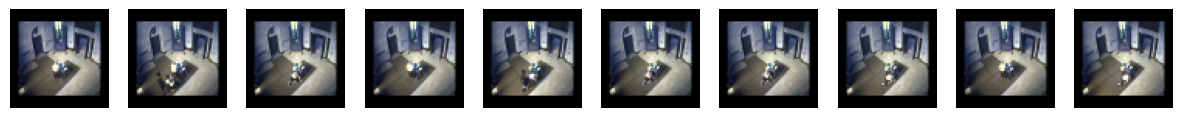

In [15]:
import matplotlib.pyplot as plt

def show_sample_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for i, img in enumerate(frames):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

# Display a sample of frames from a video
sample_frames = process_frames("dataset/UCF_Crime_Organized/Train/Abuse/video_1", num_frames=10)
show_sample_frames(sample_frames)

In [16]:
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, Add, BatchNormalization, ReLU
from tensorflow.keras.models import Model

def resnet3d_block(x, filters, kernel_size=(3, 3, 3), stride=1):
    shortcut = x
    
    x = Conv3D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv3D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1:
        shortcut = Conv3D(filters, (1, 1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

def build_resnet3d(input_shape=(200, 64, 64, 3), num_classes=14):
    inputs = Input(shape=input_shape)
    
    x = Conv3D(64, (7, 7, 7), strides=(2, 2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling3D((3, 3, 3), strides=(2, 2, 2), padding='same')(x)
    
    # Residual blocks
    x = resnet3d_block(x, 64)
    x = resnet3d_block(x, 128, stride=2)
    x = resnet3d_block(x, 256, stride=2)
    x = resnet3d_block(x, 512, stride=2)
    
    x = GlobalAveragePooling3D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

resnet3d_model = build_resnet3d()
resnet3d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
resnet3d_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200, 64,   │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_24 (Conv3D)  │ (None, 100, 32,   │     65,920 │ input_layer_2[0]… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32,   │        256 │ conv3d_24[0][0]   │
│ (BatchNormalizatio… │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 100, 32,   │          0 │ batch_normalizat… │
│                     │ 32, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_2     │ (None, 50, 16,    │          0 │ re_lu_18[0][0]    │
│ (MaxPooling3D)      │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_25 (Conv3D)  │ (None, 50, 16,    │    110,656 │ max_pooling3d_2[… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16,    │        256 │ conv3d_25[0][0]   │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 50, 16,    │          0 │ batch_normalizat… │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_26 (Conv3D)  │ (None, 50, 16,    │    110,656 │ re_lu_19[0][0]    │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 16,    │        256 │ conv3d_26[0][0]   │
│ (BatchNormalizatio… │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 50, 16,    │          0 │ batch_normalizat… │
│                     │ 16, 64)           │            │ max_pooling3d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 50, 16,    │          0 │ add_8[0][0]       │
│                     │ 16, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_27 (Conv3D)  │ (None, 25, 8, 8,  │    221,312 │ re_lu_20[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 8, 8,  │        512 │ conv3d_27[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 25, 8, 8,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_28 (Conv3D)  │ (None, 25, 8, 8,  │    442,496 │ re_lu_21[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_29 (Conv3D)  │ (None, 25, 8, 8,  │      8,320 │ re_lu_20[0][0]  

 Total params: 14,415,246 (54.99 MB)

 Trainable params: 14,409,486 (54.97 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [17]:
# Train the 3D ResNet model
resnet3d_model.fit(X_train, y_train, validation_split=0.2, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1031s 49s/step - accuracy: 0.4592 - loss: 2.0388 - val_accuracy: 0.0000e+00 - val_loss: 4208.8755
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 977s 46s/step - accuracy: 0.6146 - loss: 1.3398 - val_accuracy: 0.0000e+00 - val_loss: 380.7929
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 971s 46s/step - accuracy: 0.5944 - loss: 1.2846 - val_accuracy: 0.0000e+00 - val_loss: 54.7677
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 997s 47s/step - accuracy: 0.6401 - loss: 1.1685 - val_accuracy: 0.0000e+00 - val_loss: 32.7001
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 949s 44s/step - accuracy: 0.6584 - loss: 1.0661 - val_accuracy: 0.0000e+00 - val_loss: 11.5989
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 930s 44s/step - accuracy: 0.6727 - loss: 0.9981 - val_accuracy: 0.0000e+00 - val_loss: 9.9464
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 941s 44s/step - accuracy: 0.6607 - loss: 1.0016 - val_accuracy: 0.0000e+00 - val_loss: 15.3937
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 979s 46s/step - accuracy: 0.

In [18]:
resnet3d_model.save("resnet3d_model.h5")
resnet3d_model.save("resnet3d_model.keras")

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step


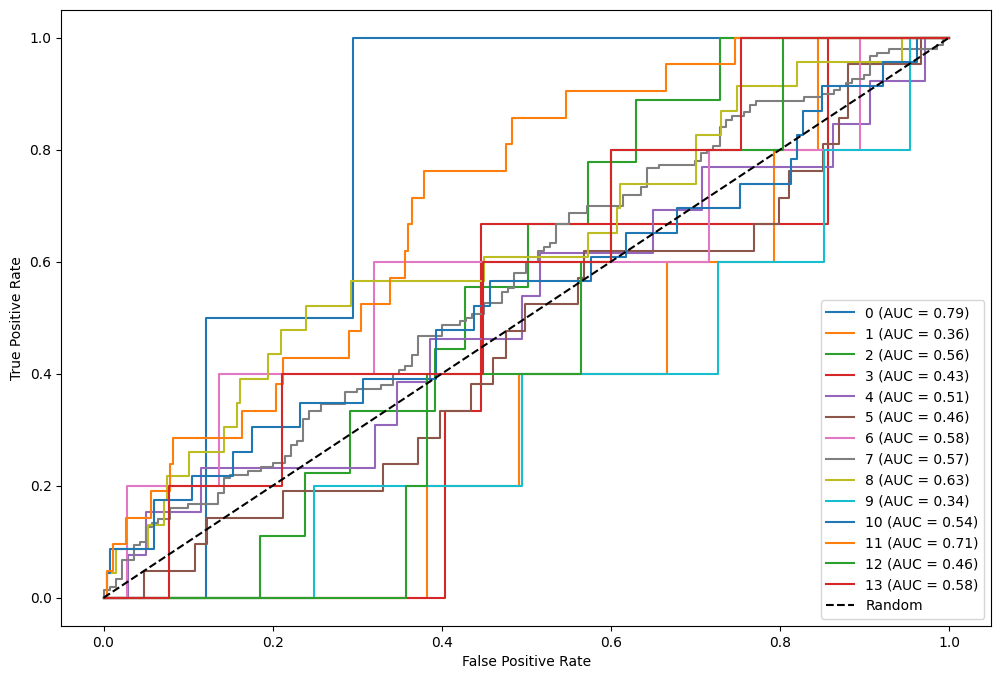

In [19]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_test, y_pred, class_labels):
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot ROC for each class
    for i, label in enumerate(lb.classes_):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        ax.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

# Example usage with predictions
y_pred_resnet3d = resnet3d_model.predict(X_test)

# Plot ROC-AUC for each model
plot_multiclass_roc(y_test, y_pred_resnet3d, CLASS_LABELS)


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step


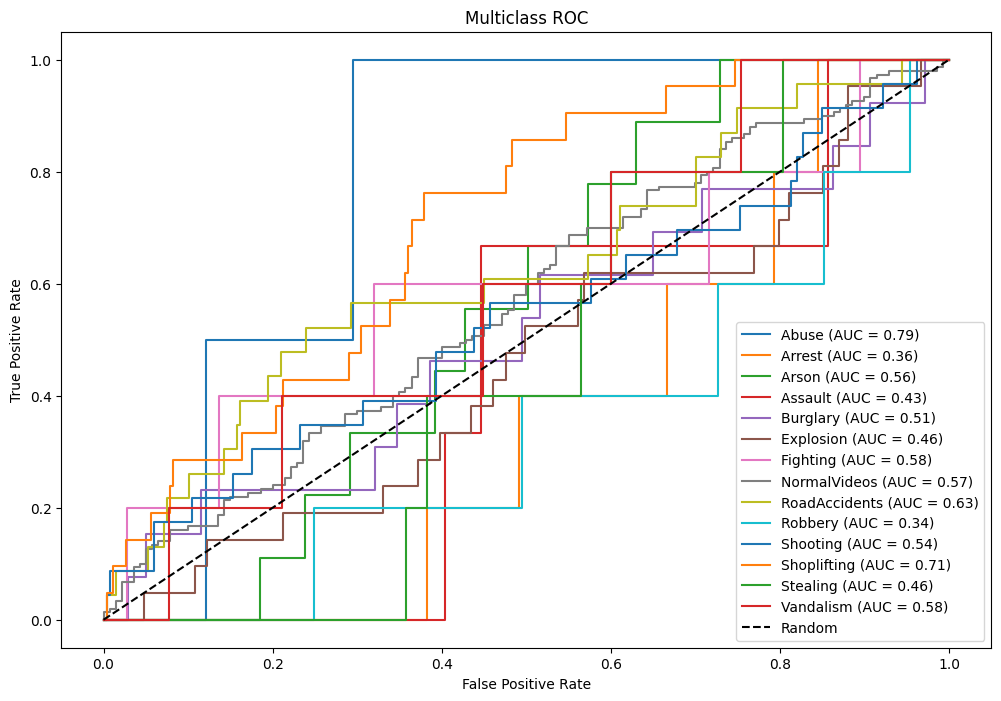

In [20]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def plot_multiclass_roc(y_test, y_pred, class_labels):
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot ROC for each class using class_labels for clarity
    for i, label in enumerate(class_labels):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred[:, i])
        ax.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

    # Plot the random chance line
    ax.plot([0, 1], [0, 1], 'k--', label='Random')
    ax.set_title('Multiclass ROC')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

# Example usage with predictions
y_pred_resnet3d = resnet3d_model.predict(X_test)

# Plot ROC-AUC for each class using the defined class labels
plot_multiclass_roc(y_test, y_pred_resnet3d, CLASS_LABELS)
